<a href="https://colab.research.google.com/github/JeanJulesBigeard/Getting-started-with-OpenCV/blob/master/Automatic%20License%20Plate%20Recognition/5_ALPR_using_WPOD_Net_LP_Tesseract_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALPR using WPOD-Net as LP Detector and Tesseract as OCR

## Introduction

In this notebook, we will implement Automatic License Plate Recognition (ALPR) system composed by
1. Vehicle Detection using **YOLOv2** network trained on PASCAL-VOC dataset
1. License Plate (LP) Detection using **Warped Planar Object Detection Network** (WPOD-Net) proposed in **License Plate Detection and Recognition in Unconstrained Scenarios** by S. M. Silva and C. R. Jung [[paper](http://openaccess.thecvf.com/content_ECCV_2018/papers/Sergio_Silva_License_Plate_Detection_ECCV_2018_paper.pdf)] [[webpage](http://www.inf.ufrgs.br/~smsilva/alpr-unconstrained/)][[github](https://github.com/sergiomsilva/alpr-unconstrained)]
1. Optical Character Recognition (OCR) using **Tesseract**

The ALPR implementation process involve,
1. Vehicle Detection
```
    1.1 Download weights and config file of YOLOv2 network trained on PASCAL-VOC dataset
    1.2 Utility functions
    1.3 Detect vehicles
```
2. License Plate Detection
```
    2.1 Download weights of pretrained WPOD-Net
    2.2 Utility functions
    2.3 Detect license plates
```
3. Optical Character Recognition
```
    3.1 Install tesseract
    3.2 Recognize characters
```
4. Inference
```
    4.1 Download the test image
    4.2 Utility functions
    4.3 Infer on the test image
    4.4 Display inference
    4.5 Observations
```

## 1. Vehicle Detection

Vehicle detection is the first step in ALPR system. Vehicles are one of the underlying objects present in many classical detection and recognition datasets, such as PASCAL-VOC, ImageNet, and COCO.

We will use pretrained YOLOv2 network trained on PASCAL-VOC dataset to perform vehicle detection. 
We will use weights and config file of YOLOv2 from [here](http://www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/vehicle-detector/), which is same as used by S. M. Silva an author of **License Plate Detection and Recognition in Unconstrained Scenarios**. The model was trained for 20 different object classes. The full list of class names can be found [here](http://www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/vehicle-detector/voc.names).

We will not perform any change or refinement to YOLOv2, just we will use the network as a black box, merging the outputs related to vehicles (i.e. cars and buses), and ignoring the other classes.





### 1.1 Download weights and config file of YOLOv2 network trained on PASCAL-VOC dataset

In [1]:
!wget -c -N www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/vehicle-detector/yolo-voc.cfg     -P vehicle-detector/
!wget -c -N www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/vehicle-detector/voc.data         -P vehicle-detector/
!wget -c -N www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/vehicle-detector/yolo-voc.weights -P vehicle-detector/
!wget -c -N www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/vehicle-detector/voc.names        -P vehicle-detector/

--2020-06-09 16:52:41--  http://www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/vehicle-detector/yolo-voc.cfg
Resolving www.inf.ufrgs.br (www.inf.ufrgs.br)... 143.54.11.34
Connecting to www.inf.ufrgs.br (www.inf.ufrgs.br)|143.54.11.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2721 (2.7K) [text/plain]
Saving to: ‘vehicle-detector/yolo-voc.cfg’

yolo-voc.cfg        100%[===================>]   2.66K  --.-KB/s    in 0s      

2020-06-09 16:52:41 (341 MB/s) - ‘vehicle-detector/yolo-voc.cfg’ saved [2721/2721]

--2020-06-09 16:52:42--  http://www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/vehicle-detector/voc.data
Resolving www.inf.ufrgs.br (www.inf.ufrgs.br)... 143.54.11.34
Connecting to www.inf.ufrgs.br (www.inf.ufrgs.br)|143.54.11.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69 [text/plain]
Saving to: ‘vehicle-detector/voc.data’

voc.data            100%[===================>]      69  --.-KB/s    in 0s      

2020-06-09 16

### 1.2 Utility functions

Here, we define few utility functions like,
- `getOutputsNames`: Get the names of the output layers for given input neural network.
- `postprocess`: to get rid of detected bounding box with low confidence
- `drawPred:` to draw the predicted bounding box
- `crop_region:` to crop out specified region from given input image

We also define `Label` a bounding box class. All detected bounding boxs are stored as an object of this class.

In [0]:
#@title
# Get the names of the output layers
def getOutputsNames(net):
  """ Get the names of the output layers.
  
  Generally in a sequential CNN network there will be 
  only one output layer at the end. In the YOLOv3 
  architecture, there are multiple output layers giving
  out predictions. This function gives the names of the 
  output layers. An output layer is not connected to 
  any next layer.
  
  Args
    net : neural network
  """
  # Get the names of all the layers in the network
  layersNames = net.getLayerNames()
  # Get the names of the output layers, i.e. the layers with unconnected outputs
  return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

import cv2 as cv
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs, confThreshold, nmsThreshold=0.4):
  frameHeight = frame.shape[0]
  frameWidth = frame.shape[1]

  classIds = []
  confidences = []
  boxes = []
  # Scan through all the bounding boxes output from the network and keep only the
  # ones with high confidence scores. Assign the box's class label as the class with the highest score.
  classIds = []
  confidences = []
  boxes = []
  predictions = []

  for out in outs:
    for detection in out:
      scores = detection[5:]
      classId = np.argmax(scores)
      confidence = scores[classId]
      if confidence > confThreshold:
        center_x = int(detection[0] * frameWidth)
        center_y = int(detection[1] * frameHeight)
        width = int(detection[2] * frameWidth)
        height = int(detection[3] * frameHeight)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)
        classIds.append(classId)
        confidences.append(float(confidence))
        boxes.append([left, top, width, height])

  # Perform non maximum suppression to eliminate redundant overlapping boxes with
  # lower confidences.
  if nmsThreshold:
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
  else:
    indices = [[x] for x in range(len(boxes))]

  for i in indices:
    i = i[0]
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    predictions.append([classIds[i], confidences[i], [left, top, left + width, top + height]])

  return predictions

import cv2 as cv
# Draw the predicted bounding box
def drawPred(frame, pred):
  classId = pred[0]
  conf = pred[1]
  box = pred[2]
  left, top, right, bottom =  box[0], box[1], box[2], box[3]
  # draw bounding box
  cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

import numpy as np

class Label:

	def __init__(self,cl=-1,tl=np.array([0.,0.]),br=np.array([0.,0.]),prob=None):
		self.__tl 	= tl
		self.__br 	= br
		self.__cl 	= cl
		self.__prob = prob

	def __str__(self):
		return 'Class: %d, top_left(x:%f,y:%f), bottom_right(x:%f,y:%f)' % (self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

	def copy(self):
		return Label(self.__cl,self.__tl,self.__br)

	def wh(self): return self.__br-self.__tl

	def cc(self): return self.__tl + self.wh()/2

	def tl(self): return self.__tl
 
	def br(self): return self.__br

	def tr(self): return np.array([self.__br[0],self.__tl[1]])

	def bl(self): return np.array([self.__tl[0],self.__br[1]])

	def cl(self): return self.__cl

	def area(self): return np.prod(self.wh())

	def prob(self): return self.__prob

	def set_class(self,cl):
		self.__cl = cl

	def set_tl(self,tl):
		self.__tl = tl

	def set_br(self,br):
		self.__br = br

	def set_wh(self,wh):
		cc = self.cc()
		self.__tl = cc - .5*wh
		self.__br = cc + .5*wh

	def set_prob(self,prob):
		self.__prob = prob

def crop_region(I,label,bg=0.5):

  wh = np.array(I.shape[1::-1])

  ch = I.shape[2] if len(I.shape) == 3 else 1
  tl = np.floor(label.tl()*wh).astype(int)
  br = np.ceil (label.br()*wh).astype(int)
  outwh = br-tl

  if np.prod(outwh) == 0.:
    return None

  outsize = (outwh[1],outwh[0],ch) if ch > 1 else (outwh[1],outwh[0])
  if (np.array(outsize) < 0).any():
    pause()
  Iout  = np.zeros(outsize,dtype=I.dtype) + bg

  offset  = np.minimum(tl,0)*(-1)
  tl      = np.maximum(tl,0)
  br      = np.minimum(br,wh)
  wh      = br - tl

  Iout[offset[1]:(offset[1] + wh[1]),offset[0]:(offset[0] + wh[0])] = I[tl[1]:br[1],tl[0]:br[0]]

  return Iout

### 1.3 Detect vehicles

Let's define the `vehicle_detection` function which takes an image as input and return `Icars` list of cropped images of vehicles as well as `Lcars` list of bouding box around vehicles. 

We use `postprocess` utility function to get rid of detected bounding box with low confidence. The `postprocess` utility function internally uses `cv.dnn.NMSBoxes` which perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences. We keep only those bounding boxs whose corresponding `classId` is either `car` (class number 6) or `bus` (class number 7), since this two `classId` are related to vehicles.

We will use `vehicle_detection` function as first step in our ALPR system implementation. 

In [0]:
# Import necessary modules
import cv2 as cv
import numpy as np

# Initialize the parameters
vehicle_threshold = .5
vehicle_weights = 'vehicle-detector/yolo-voc.weights'
vehicle_netcfg  = 'vehicle-detector/yolo-voc.cfg'

# Load the model
vehicle_net = cv.dnn.readNetFromDarknet(vehicle_netcfg, vehicle_weights)
vehicle_net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
vehicle_net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

def vehicle_detection(frame):

  # Create a 4D blob from a frame.
  blob = cv.dnn.blobFromImage(frame, 1/255, (416, 416), [0,0,0], 1, crop=False)

  # Sets the input to the network
  vehicle_net.setInput(blob)

  # Runs the forward pass to get output of the output layers
  outs = vehicle_net.forward(getOutputsNames(vehicle_net))

  # Remove the bounding boxes with low confidence
  R = postprocess(frame, outs, vehicle_threshold)
  
  Icars = []
  Lcars = []

  if len(R):
    WH = np.array(frame.shape[1::-1], dtype=float)
    for i, r in enumerate(R):
      # if classId in ['car', 'bus'] and confidence > vehicle_threshold
      if r[0] in [6, 7] and r[1] > vehicle_threshold:
        box = r[2]
        x1,y1,x2,y2 = (np.array(r[2])/np.concatenate((WH,WH))).tolist()
        tl = np.array([x1, y1])
        br = np.array([x2, y2])
        label = Label(0,tl,br)
        Lcars.append(label)
        Icar = crop_region(frame,label)
        Icars.append(Icar.astype(np.uint8))

  return Icars, Lcars 

## 2. License Plate Detection

License plates are intrinsically rectangular and planar objects, which are attached to vehicles for identification purposes. To take advantage of its shape, the author proposed a novel CNN called **Warped Planar Object Detection Network**.

This network learns to detect LPs in a variety of different distortions, and regresses coefficients of an affine transformation that unwarps the distorted LP into a rectangular shape resembling a frontal view.

![Fully convolutional detection of planar objects](https://www.dropbox.com/s/a9u69cgtsguemkg/WPOD.png?dl=1)






### WPOD-Net Architecture

The proposed architecture has a total of 21 convolutional layers, where 14 are inside residual blocks. The size of all convolutional filters is fixed in 3 × 3. ReLU activations are used throughout the entire network, except in the detection block. There are 4 max pooling layers of size 2×2 and stride 2 that reduces the input dimensionality by a factor of 16. 

Finally, the detection block has two parallel convolutional layers: 
(i) one for inferring the probability, activated by a softmax function, and (ii) another for regressing the affine parameters, without activation.

![WPOD-NET Architecture](https://www.dropbox.com/s/vjeiwilm6ntd8xm/WPOD_Net.png?dl=1)

We will use latest version of weights of pretrained WPOD-Net from [here](http://www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/lp-detector), which is same as used by the author.

### 2.1 Download weights of pretrained WPOD-Net

In [4]:
!wget -c -N www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/lp-detector/wpod-net_update1.h5   -P lp-detector/
!wget -c -N www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/lp-detector/wpod-net_update1.json -P lp-detector/ 

--2020-06-09 16:52:59--  http://www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/lp-detector/wpod-net_update1.h5
Resolving www.inf.ufrgs.br (www.inf.ufrgs.br)... 143.54.11.34
Connecting to www.inf.ufrgs.br (www.inf.ufrgs.br)|143.54.11.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6795496 (6.5M) [text/plain]
Saving to: ‘lp-detector/wpod-net_update1.h5’

wpod-net_update1.h5 100%[===================>]   6.48M  5.51MB/s    in 1.2s    

2020-06-09 16:53:00 (5.51 MB/s) - ‘lp-detector/wpod-net_update1.h5’ saved [6795496/6795496]

--2020-06-09 16:53:01--  http://www.inf.ufrgs.br/~smsilva/alpr-unconstrained/data/lp-detector/wpod-net_update1.json
Resolving www.inf.ufrgs.br (www.inf.ufrgs.br)... 143.54.11.34
Connecting to www.inf.ufrgs.br (www.inf.ufrgs.br)|143.54.11.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39635 (39K) [text/plain]
Saving to: ‘lp-detector/wpod-net_update1.json’

wpod-net_update1.js 100%[===================>]  38.71

### 2.2 Utility functions

There are few utility functions which has been taken from the author [github](https://github.com/sergiomsilva/alpr-unconstrained). These utility functions are,
- `nms`: to perform non maximum suppression
- `IOU`: to calculate intersection over union for given two bounding box interm of pair of top-left and bottom-right corners 
- `IOU_label`: to calculate intersection over union for given two bounding box interm of an object of `Label` class
- `find_T_matrix`: to calculate affine transformation for given set of source points and destination points 
- `reconstruct`: to perform license plate rectification using calculated affine transformation
- `detect_lp`: to perform license plate detection using  WPOD-Net 

In [0]:
#@title
import cv2 as cv
import numpy as np
import time

class DLabel (Label):

	def __init__(self,cl,pts,prob):
		self.pts = pts
		tl = np.amin(pts,1)
		br = np.amax(pts,1)
		Label.__init__(self,cl,tl,br,prob)

def nms(Labels,iou_threshold=.5):

  SelectedLabels = []
  Labels.sort(key=lambda l: l.prob(),reverse=True)
  
  for label in Labels:
    non_overlap = True
    for sel_label in SelectedLabels:
      if IOU_labels(label,sel_label) > iou_threshold:
        non_overlap = False
        break
    if non_overlap:
      SelectedLabels.append(label)

  return SelectedLabels

def IOU(tl1,br1,tl2,br2):
  wh1,wh2 = br1-tl1,br2-tl2
  assert((wh1>=.0).all() and (wh2>=.0).all())
  
  intersection_wh = np.maximum(np.minimum(br1,br2) - np.maximum(tl1,tl2),0.)
  intersection_area = np.prod(intersection_wh)
  area1,area2 = (np.prod(wh1),np.prod(wh2))
  union_area = area1 + area2 - intersection_area;
  return intersection_area/union_area

def IOU_labels(l1,l2):
  return IOU(l1.tl(),l1.br(),l2.tl(),l2.br())

def getRectPts(tlx,tly,brx,bry):
	return np.matrix([[tlx,brx,brx,tlx],[tly,tly,bry,bry],[1.,1.,1.,1.]],dtype=float)

def find_T_matrix(pts,t_pts):
	A = np.zeros((8,9))
	for i in range(0,4):
		xi  = pts[:,i];
		xil = t_pts[:,i];
		xi  = xi.T
		
		A[i*2,   3:6] = -xil[2]*xi
		A[i*2,   6: ] =  xil[1]*xi
		A[i*2+1,  :3] =  xil[2]*xi
		A[i*2+1, 6: ] = -xil[0]*xi

	
	[U,S,V] = np.linalg.svd(A)
	H = V[-1,:].reshape((3,3))

	return H

def reconstruct(Iorig,I,Y,out_size,threshold=.9):
   
	net_stride 	= 2**4
	side 		= ((208. + 40.)/2.)/net_stride # 7.75

	Probs = Y[...,0]
	# print Probs
	Affines = Y[...,2:]
	rx,ry = Y.shape[:2]
	# print Y.shape
	ywh = Y.shape[1::-1]
	# print ywh
	iwh = np.array(I.shape[1::-1],dtype=float).reshape((2,1))
	# print iwh

	xx,yy = np.where(Probs>threshold)
	# print xx,yy

	WH = getWH(I.shape)
	MN = WH/net_stride

	# print MN

	vxx = vyy = 0.5 #alpha

	base = lambda vx,vy: np.matrix([[-vx,-vy,1.],[vx,-vy,1.],[vx,vy,1.],[-vx,vy,1.]]).T
	labels = []

	for i in range(len(xx)):
		y,x = xx[i],yy[i]
		affine = Affines[y,x]
		prob = Probs[y,x]

		mn = np.array([float(x) + .5,float(y) + .5])

		A = np.reshape(affine,(2,3))
		A[0,0] = max(A[0,0],0.)
		A[1,1] = max(A[1,1],0.)
		# print A
		pts = np.array(A*base(vxx,vyy)) #*alpha
		# print pts
		pts_MN_center_mn = pts*side
		pts_MN = pts_MN_center_mn + mn.reshape((2,1))

		pts_prop = pts_MN/MN.reshape((2,1))

		labels.append(DLabel(0,pts_prop,prob))

	# print(labels)
	final_labels = nms(labels,.1)
	TLps = []

	if len(final_labels):
		final_labels.sort(key=lambda x: x.prob(), reverse=True)
		for i,label in enumerate(final_labels):

			t_ptsh 	= getRectPts(0,0,out_size[0],out_size[1])
			ptsh 	= np.concatenate((label.pts*getWH(Iorig.shape).reshape((2,1)),np.ones((1,4))))
			H 		= find_T_matrix(ptsh,t_ptsh)
			Ilp 	= cv.warpPerspective(Iorig,H,out_size,borderValue=.0)
			# cv.imshow("frame", Iorig)
			# cv.waitKey(0)

			TLps.append(Ilp)

	return final_labels,TLps

def im2single(I):
  assert(I.dtype == 'uint8')
  return I.astype('float32')/255.

def getWH(shape):
  return np.array(shape[1::-1]).astype(float)


In [0]:
def detect_lp(model,I,max_dim,net_step,out_size,threshold):

	min_dim_img = min(I.shape[:2])
	factor 		= float(max_dim)/min_dim_img
	# print I.shape[:2]

	w,h = (np.array(I.shape[1::-1],dtype=float)*factor).astype(int).tolist()
	w += (w%net_step!=0)*(net_step - w%net_step)
	h += (h%net_step!=0)*(net_step - h%net_step)
	# print w
	# print h
	Iresized = cv.resize(I,(w,h))

	T = Iresized.copy()
	T = T.reshape((1,T.shape[0],T.shape[1],T.shape[2]))

	start 	= time.time()
	Yr 		= model.predict(T)
	Yr 		= np.squeeze(Yr)
	elapsed = time.time() - start
	# print(Yr)
	L,TLps = reconstruct(I,Iresized,Yr,out_size,threshold)

	return L,TLps,elapsed

### 2.3 Detect license plates

Let's define a `lp_detection` function which takes vehicle image as input and return `Llps` list of bounding boxs around detected license plates and `Ilps` list of croppsed images of detected license plates.

Again, we use `postprocess` utility function to remove bouding box with low threshold.  

In [7]:
# Import necessary modules
from keras.models import model_from_json

# Initialize the parameters
lp_threshold = .6
wpod_lp_weights_path = 'lp-detector/wpod-net_update1.h5'
wpod_lp_json_path    = 'lp-detector/wpod-net_update1.json'

# Load the model
with open(wpod_lp_json_path,'r') as json_file:
  wpod_json = json_file.read()
lp_net = model_from_json(wpod_json)
lp_net.load_weights(wpod_lp_weights_path)

def lp_detection(vehicle_img):

  ratio = float(max(vehicle_img.shape[:2]))/min(vehicle_img.shape[:2])
  side  = int(ratio * 288.)
  bound_dim = min(side + (side % (2**4) ), 608)
  Llps, LlpImgs, elapsed = detect_lp(lp_net,im2single(vehicle_img),bound_dim,2**4,(240,80),lp_threshold)
  
  Ilps = []
  for LlpImg in LlpImgs:
    Ilp = LlpImg * 255.
    Ilps.append(Ilp.astype(np.uint8))

  return Llps, Ilps, elapsed

Using TensorFlow backend.


## 3. Optical Character Recognition

OCR is third and last step in ALPR system. In this step, for each detected license plate we apply OCR for a) character segmentation and b) character recognition.

We will use tesseract OCR engine for recognizing and converting text of license plate into machine-encoded string. 

### 3.1 Install tesseract

[Tesseract](https://github.com/tesseract-ocr/tesseract) is an optical character recognition (OCR) engine. That is, it will recognize and “read” the text embedded in images.

In [8]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,536 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

### 3.2 Recognize characters

Let's define a `lp_ocr` function which takes image of license plate as input, apply tesseract OCR engine, converts license plate text into string and return that string as output. 

In [0]:
# Import necessary modules
import cv2 as cv
import pytesseract

def lp_ocr(lp_img):
  gray_lp_img = cv.cvtColor(lp_img, cv.COLOR_BGR2GRAY)
  lp_str = pytesseract.image_to_string(gray_lp_img, config=("-l eng --oem 1 --psm 13"))    
  return lp_str

## 4. Inference



We have already defined 1) `vehicle_detection` 2) `lp_detection` and 3) `lp_ocr` to perform vehicle detection, license plate detection and OCR respectively. 

Let's implement our ALPR systen which is compised all these three function in a sequential pipeline. 

### 4.1 Download the test image

In [10]:
!wget "https://raw.githubusercontent.com/sergiomsilva/alpr-unconstrained/master/samples/test/03066.jpg" -O test_img.jpg

--2020-06-09 16:53:19--  https://raw.githubusercontent.com/sergiomsilva/alpr-unconstrained/master/samples/test/03066.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160770 (157K) [image/jpeg]
Saving to: ‘test_img.jpg’

test_img.jpg        100%[===================>] 157.00K  --.-KB/s    in 0.04s   

2020-06-09 16:53:19 (3.75 MB/s) - ‘test_img.jpg’ saved [160770/160770]



### 4.2 Utility functions

Here, we define few utility functions like,
- `draw_label`: to draw bounding box using object of `Label` class as input
- `draw_losangle`: to draw bouding box using a set of four corner points.
- `write2img`: to write text on a input image around given bounding box. 

In [0]:
#@title
import numpy as np
import cv2 as cv

def draw_label(I,l,color=(255,0,0),thickness=1):
	wh = np.array(I.shape[1::-1]).astype(float)
	tl = tuple((l.tl()*wh).astype(int).tolist())
	br = tuple((l.br()*wh).astype(int).tolist())
	cv.rectangle(I,tl,br,color,thickness=thickness)

def draw_losangle(I,pts,color=(1.,1.,1.),thickness=1):
	assert(pts.shape[0] == 2 and pts.shape[1] == 4)

	for i in range(4):
		pt1 = tuple(pts[:,i].astype(int).tolist())
		pt2 = tuple(pts[:,(i+1)%4].astype(int).tolist())
		cv.line(I,pt1,pt2,color,thickness)

def write2img(Img,label,strg,txt_color=(0,0,0),bg_color=(255,255,255),font_size=1):
	wh_img = np.array(Img.shape[1::-1])

	font = cv.FONT_HERSHEY_SIMPLEX

	wh_text,v = cv.getTextSize(strg, font, font_size, 3)
	bl_corner = label.tl()*wh_img

	tl_corner = np.array([bl_corner[0],bl_corner[1]-wh_text[1]])/wh_img
	br_corner = np.array([bl_corner[0]+wh_text[0],bl_corner[1]])/wh_img
	bl_corner /= wh_img

	if (tl_corner < 0.).any():
		delta = 0. - np.minimum(tl_corner,0.)
	elif (br_corner > 1.).any():
		delta = 1. - np.maximum(br_corner,1.)
	else:
		delta = 0.

	tl_corner += delta
	br_corner += delta
	bl_corner += delta

	tpl = lambda x: tuple((x*wh_img).astype(int).tolist())

	cv.rectangle(Img, tpl(tl_corner), tpl(br_corner), bg_color, -1)	
	cv.putText(Img,strg,tpl(bl_corner),font,font_size,txt_color,3)

### 4.3 Infer on the test image


To infer on the test image we apply
- first, `vehicle_detection` to detect all vehicles in an input test image. Output of this step is `Icars` a list of cropped vehicles regions as well as `Lcars` a list of bounding boxs around detected vehicles.

- second, `lp_detection` on each cropped vehicle regions in `Icars` to detect license plates. Output of this step is `Llps` a list of bouding boxs around detected license plate as well as `Ilps` cropped images of license plate in given vehicle image.

- third, `lo_ocr` on each cropped license plate region in `Ilps` to convert licese plat text in it to a string.

- finally, `write2img` to write recognized license plat charactes on the input test image.




In [12]:
# Import necessary modules
import numpy as np
import cv2 as cv
# read test image
test_img = cv.imread('test_img.jpg')
# detect cars
Icars, Lcars = vehicle_detection(test_img)
print('# vehicle detected: {}'.format(len(Icars)))
# for each detected car in test image
for Icar, Lcar in zip(Icars, Lcars):
  # draw car bounding box on test image
  draw_label(test_img,Lcar,color=(0,255,255),thickness=3)
  # detect LP in detected car
  Llps, Ilps, elapsed = lp_detection(Icar)   
  # for each detected LP in detected car image
  for Llp, Ilp in zip(Llps, Ilps):
    # draw LP bounding box on test image
    pts = Llp.pts*Lcar.wh().reshape(2,1) + Lcar.tl().reshape(2,1)
    ptspx = pts*np.array(test_img.shape[1::-1],dtype=float).reshape(2,1)
    draw_losangle(test_img,ptspx,color=(0,0,255),thickness=3)
    # Recognize characters
    lp_str = lp_ocr(Ilp)
    # write text on test image
    llp = Label(0,tl=pts.min(1),br=pts.max(1))
    write2img(test_img,llp,lp_str)

# vehicle detected: 3


### 4.4 Display inference

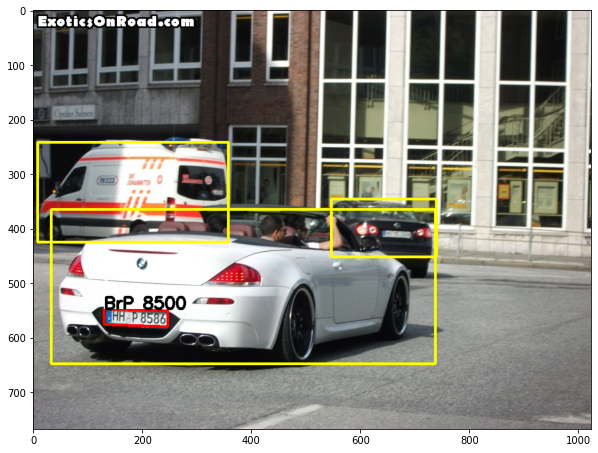

In [13]:
# Import necessary modules
import matplotlib
import matplotlib.pyplot as plt
# Display inference
fig=plt.figure(figsize=(10, 10))
plt.imshow(test_img[:,:,::-1])
plt.show()

### 4.5 Observations


From the above result we can make following observations,

- WPOD-Net is able to predict tighter bounding box around license plate as compared to YOLO-Net.

- Still the performance tesseract as OCR is not satisfactory.

In the next notebook, lets see how the WPOD-NET and trained OCR gives better results for ALPR systems.